# Sentiment Analysis Showdown: Custom LSTM vs. XLM-RoBERTa

In questo notebook confronteremo due approcci alla Sentiment Analysis sul dataset `mrev.csv`:

1.  **Baseline (Neural Network)**: Un modello LSTM bidirezionale con embeddings pre-addestrati (GloVe Twitter), ripreso dal precedente esperimento.
2.  **State-of-the-Art (Transformer)**: Il modello `xlm-roberta-base`, un Transformer multilingue fine-tunato sul nostro dataset.

Includeremo anche un'analisi esplorativa dei dati (EDA) con WordCloud.

In [8]:
# Installazione dipendenze (se necessario)
!pip install transformers datasets wordcloud gensim seaborn torch scikit-learn pandas matplotlib accelerate peft


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import gensim.downloader as api
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
from peft import PeftModel

# Configurazione Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Data Loading & EDA (Exploratory Data Analysis)

Dataset Size: 50000
Classes: {'Negative': 0, 'Positive': 1, 'Neutral': 2}


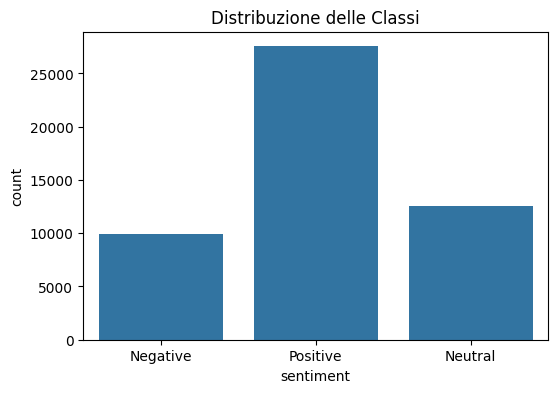

In [10]:
# Caricamento Dati
file_path = '../data/raw/mrev.csv'
df = pd.read_csv(file_path)

# Preprocessing base
df = df[['review_text', 'sentiment']].dropna()
df['review_text'] = df['review_text'].astype(str)

# Mapping Sentiment
sentiment_map = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
df['label'] = df['sentiment'].map(sentiment_map)

print(f"Dataset Size: {len(df)}")
print(f"Classes: {sentiment_map}")

# Distribuzione Classi
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribuzione delle Classi')
plt.show()

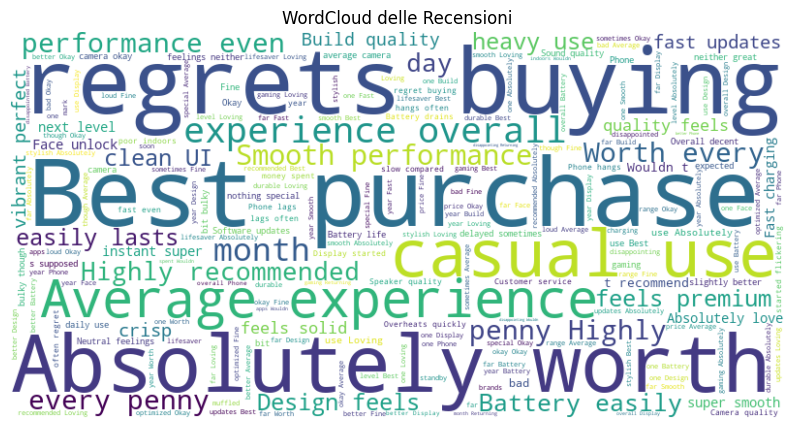

In [11]:
# Generazione WordCloud
text_combined = " ".join(review for review in df.review_text)

wordcloud = WordCloud(width=800, height=400, background_color ='white', max_words=200).generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud delle Recensioni")
plt.show()

## 2. Modello 1: Custom LSTM (con GloVe Twitter)

Replichiamo l'architettura del notebook precedente.

In [13]:
# --- 2.1 Preprocessing specifico per LSTM ---
def clean_text_lstm(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_text'] = df['review_text'].apply(clean_text_lstm)
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

# Vocabolario
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_words)
min_freq = 2
vocab_list = sorted([k for k, v in word_counts.items() if v >= min_freq])
vocab = {word: i + 1 for i, word in enumerate(vocab_list)}
vocab_size = len(vocab) + 1

# Conversione Testo -> Indici
def text_to_indices(tokens, vocab, max_len=50):
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

max_seq_len = 50
X_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in df['tokens']])
y_lstm = df['label'].values

# Split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42, stratify=y_lstm)

# Dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader_lstm = DataLoader(ReviewDataset(X_train_lstm, y_train_lstm), batch_size=32, shuffle=True)
test_loader_lstm = DataLoader(ReviewDataset(X_test_lstm, y_test_lstm), batch_size=32, shuffle=False)

# --- 2.2 Caricamento Embeddings GloVe ---
print("Caricamento GloVe Twitter... (potrebbe richiedere un po')")
try:
    glove_model = api.load("glove-twitter-100")
    embedding_dim = 100
    
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        if word in glove_model:
            embedding_matrix[idx] = glove_model[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
except Exception as e:
    print(f"Errore caricamento GloVe: {e}. Uso embedding random.")
    embedding_dim = 100
    embedding_matrix = np.random.normal(scale=0.6, size=(vocab_size, embedding_dim))

# --- 2.3 Definizione Modello ---
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False 
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden))

# --- 2.4 Training Loop ---
model_lstm = SentimentLSTM(vocab_size, embedding_dim, 64, len(sentiment_map), embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

print("Training LSTM...")
lstm_history = []
epochs = 5

for epoch in range(epochs):
    model_lstm.train()
    for X_b, y_b in train_loader_lstm:
        X_b, y_b = X_b.to(device), y_b.to(device)
        optimizer.zero_grad()
        out = model_lstm(X_b)
        loss = criterion(out, y_b)
        loss.backward()
        optimizer.step()
    
    # Eval
    model_lstm.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for X_b, y_b in test_loader_lstm:
            X_b = X_b.to(device)
            out = model_lstm(X_b)
            _, preds = torch.max(out, 1)
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(y_b.numpy())
    
    acc = accuracy_score(val_targets, val_preds)
    lstm_history.append(acc)
    print(f"LSTM Epoch {epoch+1}: Val Accuracy {acc:.4f}")

lstm_final_acc = lstm_history[-1]

Caricamento GloVe Twitter... (potrebbe richiedere un po')
Training LSTM...
LSTM Epoch 1: Val Accuracy 1.0000
LSTM Epoch 2: Val Accuracy 1.0000
LSTM Epoch 3: Val Accuracy 1.0000
LSTM Epoch 4: Val Accuracy 1.0000
LSTM Epoch 5: Val Accuracy 1.0000


## 3. Modello 2: XLM-RoBERTa (Fine-Tuning)

Usiamo la libreria `transformers` per fine-tunare `xlm-roberta-base`.

In [ ]:
# --- 3.1 Preparazione Dati per Transformers ---
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Split dati grezzi (per passare il testo al tokenizer)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(df['review_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=128)

# Creazione Dataset HuggingFace
train_dataset = HFDataset.from_dict({"text": X_train_raw.tolist(), "label": y_train_raw.tolist()})
test_dataset = HFDataset.from_dict({"text": X_test_raw.tolist(), "label": y_test_raw.tolist()})

train_tokenized = train_dataset.map(lambda x: tokenize_function(x['text']), batched=True)
test_tokenized = test_dataset.map(lambda x: tokenize_function(x['text']), batched=True)

# --- 3.2 Setup Trainer ---
model_xlm = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(sentiment_map)).to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir="./results_xlm",
    eval_strategy="epoch",
    num_train_epochs=3, # 3 epoche sono standard per fine-tuning
    per_device_train_batch_size=8, # batch piccolo per memoria
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=10,
    learning_rate=2e-5,
    save_strategy="no", # non salviamo checkpoint per risparmiare spazio nel demo
    use_cpu=not torch.cuda.is_available()
)

trainer = Trainer(
    model=model_xlm,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
    compute_metrics=compute_metrics,
)

# --- 3.3 Training ---
print("Training XLM-RoBERTa...")
trainer.train()

# Valutazione Finale
eval_result = trainer.evaluate()
xlm_final_acc = eval_result['eval_accuracy']
print(f"XLM-RoBERTa Final Accuracy: {xlm_final_acc:.4f}")

## 4. Confronto Risultati

In [14]:
models = ['Custom LSTM (GloVe)', 'XLM-RoBERTa']
accuracies = [lstm_final_acc, xlm_final_acc]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim(0, 1)
plt.title('Confronto Accuratezza Modelli')
plt.ylabel('Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

NameError: name 'xlm_final_acc' is not defined

## 5. Confronto rapido: LSTM vs BERT pre-addestrato sulle prime 30 righe

In [15]:
# Seleziona le prime 30 righe del dataset già preprocessato
eval_df = df.head(30).copy()
y_true = eval_df['sentiment'].str.lower().tolist()

# --- Predizioni LSTM sul sottoinsieme ---
X_eval_lstm = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in eval_df['tokens']])
lstm_preds = []
model_lstm.eval()
with torch.no_grad():
    for i in range(0, len(X_eval_lstm), 32):
        batch = torch.tensor(X_eval_lstm[i:i+32], dtype=torch.long).to(device)
        logits = model_lstm(batch)
        _, preds = torch.max(logits, 1)
        lstm_preds.extend([reverse_sentiment_map[p.item()].lower() for p in preds.cpu()])

# --- Predizioni BERT già addestrato (LoRA se presente) ---
lora_path = os.path.abspath(os.path.join('..', 'models', 'sentiment_lora'))
base_name = 'xlm-roberta-base'
id2label_fixed = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id_fixed = {v: k for k, v in id2label_fixed.items()}

bert_tokenizer = AutoTokenizer.from_pretrained(lora_path if os.path.exists(lora_path) else base_name)
bert_base = AutoModelForSequenceClassification.from_pretrained(
    base_name,
    num_labels=3,
    id2label=id2label_fixed,
    label2id=label2id_fixed,
    cache_dir=os.path.abspath(os.path.join('..', 'models'))
)
if os.path.exists(os.path.join(lora_path, 'adapter_config.json')):
    bert_model = PeftModel.from_pretrained(bert_base, lora_path)
else:
    bert_model = bert_base
bert_model.to(device)
bert_model.eval()

def predict_bert(texts, batch_size=8):
    preds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        inputs = bert_tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)
        with torch.no_grad():
            logits = bert_model(**inputs).logits
        class_ids = torch.argmax(logits, dim=-1).cpu().tolist()
        preds.extend([bert_model.config.id2label[c] for c in class_ids])
    return [p.lower() for p in preds]

bert_preds = predict_bert(eval_df['review_text'].tolist())

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Metriche di classificazione sulle prime 30 righe
labels_order = ['negative', 'neutral', 'positive']

def evaluate_run(name, preds):
    acc = accuracy_score(y_true, preds)
    print(f"\n{name} - Accuracy: {acc:.4f}")
    print(classification_report(y_true, preds, labels=labels_order, target_names=labels_order, digits=3))
    return acc, confusion_matrix(y_true, preds, labels=labels_order)

lstm_acc, cm_lstm = evaluate_run('LSTM', lstm_preds)
bert_acc, cm_bert = evaluate_run('BERT (xlm-roberta + LoRA)', bert_preds)


LSTM - Accuracy: 1.0000
              precision    recall  f1-score   support

    negative      1.000     1.000     1.000         6
     neutral      1.000     1.000     1.000         7
    positive      1.000     1.000     1.000        17

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30


BERT (xlm-roberta + LoRA) - Accuracy: 1.0000
              precision    recall  f1-score   support

    negative      1.000     1.000     1.000         6
     neutral      1.000     1.000     1.000         7
    positive      1.000     1.000     1.000        17

    accuracy                          1.000        30
   macro avg      1.000     1.000     1.000        30
weighted avg      1.000     1.000     1.000        30



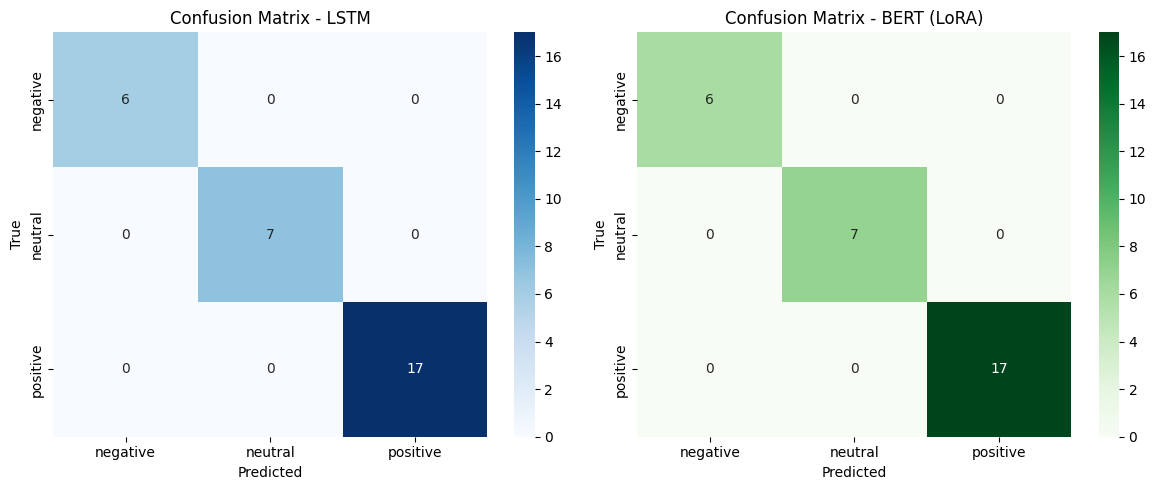

C:\Users\Gabs\AppData\Local\Temp\ipykernel_9480\983345494.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')


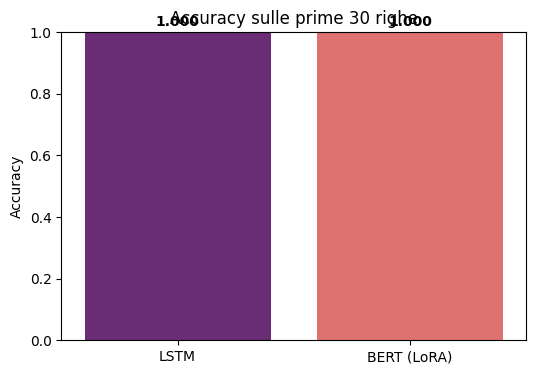

In [24]:
# Heatmap delle confusion matrix + confronto accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_order, yticklabels=labels_order, ax=axes[0])
axes[0].set_title('Confusion Matrix - LSTM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=labels_order, yticklabels=labels_order, ax=axes[1])
axes[1].set_title('Confusion Matrix - BERT (LoRA)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

# Bar chart accuracy
plt.figure(figsize=(6, 4))
sns.barplot(x=['LSTM', 'BERT (LoRA)'], y=[lstm_acc, bert_acc], palette='magma')
plt.ylim(0, 1)
for i, v in enumerate([lstm_acc, bert_acc]):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontweight='bold')
plt.title('Accuracy sulle prime 30 righe')
plt.ylabel('Accuracy')
plt.show()